# Data Preprocessing

<hr>

## 1. 부동산 데이터 통합.

### 서울 부동산 데이터

#### Data : 362만
- df_apart  : 아파트 통합본   2108355
- df_office : 오피스텔 통합본  418333
- df_multi  : 다세대 통합본   1096303

#### columns : 19개
- 시군구, 번지, 본번, 부번, 단지명, 
- 전월세구분, 전용면적(㎡), 계약년월, 계약일, 보증금(만원), 
- 월세(만원), 층, 건축년도, 도로명, 계약기간, 
- 계약구분, 갱신요구권 사용, 종전계약 보증금 (만원), 종전계약 월세 (만원)


#### Y : 전세값

- 월세 -> 전세로 환산 
- 전월세전환율
2011.02 ~ 2023.02


In [1]:
import pandas as pd
path = "./"

# 전월세 전환율
percent = pd.read_csv(path + 'percent.csv', encoding='cp949', index_col=['주택유형별(1)'])
percent = percent.drop(['지역별(1)'], axis=1).transpose()
percent.index = percent.index.str.replace('.', '').astype(int)


# 아파트 통합본 (2108355, 19)
df_apart = pd.read_csv(path + "apart.csv", encoding='cp949') 
df_apart['구분'] = '아파트'
df_apart.rename(columns={'단지명': '건물명'}, inplace=True)
df_apart = pd.merge(df_apart, percent['아파트'], left_on='계약년월', right_index=True).rename(columns={'아파트': '전환율'})


# 오피스텔 통합본 (418333, 19)
df_office = pd.read_csv(path + "office.csv", encoding='cp949')
df_office['구분'] = '오피스텔'
df_office.rename(columns={'단지명': '건물명'}, inplace=True)
df_office = pd.merge(df_office, percent['단독주택'], left_on='계약년월', right_index=True).rename(columns={'단독주택': '전환율'})


# 다세대 통합본 (1096303, 19)
df_multi = pd.read_csv(path + "multi.csv", encoding='cp949') 
df_multi['구분'] = '연립다세대'
df_multi = pd.merge(df_multi, percent['연립다세대'], left_on='계약년월', right_index=True).rename(columns={'연립다세대': '전환율'})

# 통합
df_all = pd.concat([df_apart, df_office, df_multi], axis = 0)
print("드랍하기 전 : ", df_all.shape)

# 드랍
df_all_drop = df_all.drop(['본번', '부번','전월세구분', '계약기간', '계약구분', '갱신요구권 사용',
                           '종전계약 보증금 (만원)', '종전계약 월세 (만원)', '계약일'], axis=1)
df_all_drop = df_all_drop[df_all_drop['도로명'] != ' ']

# 건물나이 추가
df_all_drop['년도'] = df_all_drop['계약년월'].astype(str).str[0:4].astype('float')
df_all_drop['건물나이'] = df_all_drop['년도'] - df_all_drop['건축년도']
df_all_drop = df_all_drop.drop(['건축년도'], axis=1)


# 시군구 분리
splited = df_all_drop['시군구'].str.split(' ', expand=True)
splited.columns = ['시','구','동']
df_all_drop=pd.concat([df_all_drop,splited], axis=1)
s_col1=df_all_drop.columns[-3:].to_list()
s_col2=df_all_drop.columns[:-3].to_list()
df_all_drop=df_all_drop[s_col1 + s_col2]
df_all_drop = df_all_drop.drop(['시군구','시'],axis=1)


# Y 연산.
df_all_drop['보증금(만원)'] = df_all_drop['보증금(만원)'].str.replace(',','').astype(int)
df_all_drop['월세(만원)'] = df_all_drop['월세(만원)'].str.replace(',','').fillna('0').astype(int)
df_all_drop['Y'] = df_all_drop.apply(lambda x: x['보증금(만원)'] + x['월세(만원)']*12*(1 + x['전환율']), axis='columns')
df_all_drop = df_all_drop.drop(['보증금(만원)', '월세(만원)', '전환율'], axis=1)


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_97640\2950738306.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  percent.index = percent.index.str.replace('.', '').astype(int)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_97640\2950738306.py:11: DtypeWarning: Columns (10,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_apart = pd.read_csv(path + "apart.csv", encoding='cp949')
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_97640\2950738306.py:18: DtypeWarning: Columns (10,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_office = pd.read_csv(path + "office.csv", encoding='cp949')
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_97640\2950738306.py:25: DtypeWarning: Columns (10,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_multi = 

드랍하기 전 :  (3622991, 21)


## 2. 금리, 코스피 추가

### 금리
201101 ~ 202303
['날짜', '한국은행기준금리']

### 코스피
201101 ~ 202301 
['날짜', '종가', '시가', '고가', '저가', '거래량', '변동 %']


In [2]:
rate = pd.read_csv(path + 'ir.csv')
kospi = pd.read_csv(path + 'kospi.csv', encoding = 'utf-8')

rate.head(n=5)
rate = rate.drop(['통계표','단위','변환'], axis=1)
rate = rate.rename(columns={'계정항목':'날짜'}).transpose()
rate.reset_index(inplace=True)
rate.columns = ['날짜','한국은행기준금리']
rate = rate.drop(rate.index[0])
rate['날짜'] = rate['날짜'].str.replace('/','').astype('int64')

kospi = kospi.drop(['시가', '고가', '저가'] , axis=1)
kospi['날짜'] = kospi['날짜'].str.replace('-','')
kospi['날짜'] = kospi['날짜'].str.replace(' ','')
kospi['날짜'] = kospi['날짜'].str[:6].astype('int64')
kospi['변동 %'] = kospi['변동 %'].str.replace('%','')
kospi['변동 %'] = kospi['변동 %'].astype('float')
kospi['거래량'] = kospi['거래량'].str.replace('B','').astype('float')
kospi['종가'] = kospi['종가'].astype('str').str.replace(',','').astype('float')

df_all_drop = pd.merge(df_all_drop, kospi, how='left', left_on='계약년월', right_on='날짜').drop(['날짜'], axis=1)
df_all_drop = pd.merge(df_all_drop, rate, left_on='계약년월', right_on='날짜').drop(['날짜'], axis=1)

df_all_drop.dropna(axis=0, inplace = True)
print(df_all_drop.shape)



(3530271, 16)


### Check Point 1

In [3]:
df_all_drop.to_csv('meta.csv', index=False)

## 3. 인프라 데이터

### 대학, 지하철 역, 마트, 스타벅스

도로명 주소 - 대학, 지하철 역 최소거리
구, 동 - 마트, 스타벅스


In [4]:
# checkpoint
df = pd.read_csv('meta.csv')
print(df.shape)
# 도로명 주소별 위 경도, 대학, 역 까지 거리 
dist = pd.read_csv('RealEstate_with_distance.csv')
df = pd.merge(df, dist, left_on='도로명', right_on='도로명')
print(df.shape)


# 동별 마트 수
market = pd.read_csv('market.csv')
df = pd.merge(df, market.groupby('지번주소').sum(), left_on='동', 
              right_index=True,  how='outer').fillna(0).rename(columns={'Unnamed: 0': '마트'})
print(df.shape)

# 스타벅스
starbucks = pd.read_csv('starbucks.csv')
address = starbucks['시/군/구'] + ' ' + starbucks['동']
count_by_address = address.value_counts()
starbucksdf = pd.DataFrame({'시군구동': count_by_address.index, '스타벅스': count_by_address.values})
starbucksdf[['구', '동']] = starbucksdf['시군구동'].str.split(expand=True)
starbucksdf = starbucksdf.drop(['시군구동'] , axis=1)
df = pd.merge(df, starbucksdf,on =['구','동'], how='outer').fillna(0)
print(df.shape)



(3530271, 16)
(3448162, 22)


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_97640\2633675145.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = pd.merge(df, market.groupby('지번주소').sum(), left_on='동',


(3448285, 23)
(3448314, 24)


In [5]:
df.columns

Index(['구', '동', '번지', '건물명', '전용면적(㎡)', '계약년월', '층', '도로명', '구분', '년도',
       '건물나이', 'Y', '종가', '거래량', '변동 %', '한국은행기준금리', '위도', '경도', '대학최소거리',
       '대학명', '역최소거리', '역명', '마트', '스타벅스'],
      dtype='object')

### Check Point 2

In [6]:
df.to_csv('meta_infra.csv', index=False)

## 4. Encoding

In [7]:
df = pd.read_csv('meta_infra.csv')

# 학습 안 시킬 컬럼 제거
not_train = ['번지', '건물명', '도로명', 
             '위도', '경도']
df = df.drop(not_train, axis=1)

Y = df.pop('Y')
df['Y'] = Y


In [8]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for name, dtype in df.dtypes.iteritems():
    if dtype == 'object':
        print(name)
        df[name] = encoder.fit_transform(df[name])

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_97640\142244864.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, dtype in df.dtypes.iteritems():


구
동
구분
대학명
역명


### Check Point 3 - Trainable Data

In [9]:
df.to_csv('Data.csv', index=False)

## 5. EDA

<AxesSubplot: >

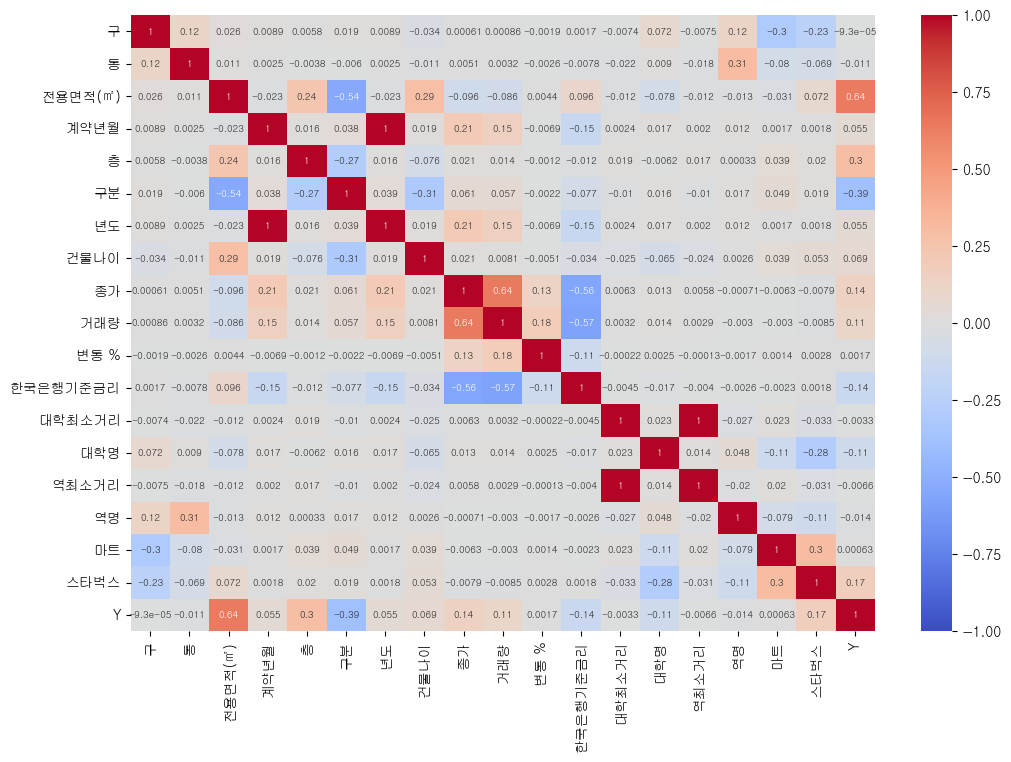

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
plt.rc('font', family='gulim')
plt.figure(figsize=(12, 8))

# 데이터프레임의 상관계수 구하기
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1, annot_kws={'size':7})
